In [1]:
import gammapy 


In this notebook the angular size of the systematic is evaulated. Therefore, we compute the sqrt ts map of the standard anlysis and compute the 2D Fourier trafo of the first energybin. The obtained angular spectrum is compared with the one computed from a dataset consisting of statistical fluctuations only (asimov dataset). The spectrum of 1000 Poission draws of this asimov dataset are plotted and used for the standard deviation estimation of the anuglar spectrum points. 

In [2]:
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import astropy
from gammapy.maps import Map
from gammapy.datasets import MapDataset
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from astropy.coordinates import SkyCoord, Angle
from regions import RectangleSkyRegion

import astropy.units as u
import yaml
import sys
sys.path.append('/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters')

import my_dataset_maps_19


spatial binsize =  [0.08] deg


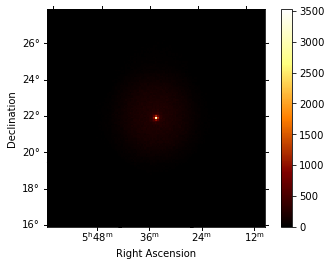

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset'
if source == "Crab":

    # here the dataset with the fine binning is saved
    dataset = MapDataset.read(f'{path}/{source}/Crab_fullsys.fits')
    #dataset = dataset.downsample(4)
    models = Models.read(f"standard_model.yml")
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    models.append(bkg_model)
    dataset.models = models

dataset.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset.geoms["geom"].width[1] / dataset.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)


In [4]:
fit_standarad = Fit(store_trace=False)
result_standarad = fit_standarad.run([dataset])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (304.31410036, -89.87572791)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (304.31410036, -89.87572791)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (244.94626658, -65.76360099)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (244.94626658, -65.76360099)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (182.89313739, 86.11089518)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (182.89313739, 86.11089518)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (323.17425385, -88.34614565)> is outside valid IRF map range, using nearest IRF defined within
P

import dataset and best fit model

In [5]:
print(
    "spatial binsize = ",
    dataset.geoms["geom"].width[1]
    / dataset.geoms["geom"].data_shape[1],
)


spatial binsize =  [0.08] deg


computation of the sqrt ts map

In [6]:
def get_residual(estart, eend, dataset_1 , smooth):
    res_1 = dataset_1.slice_by_energy(estart*u.TeV, eend*u.TeV).residuals( 'diff/sqrt(model)')
    return res_1.smooth(smooth*u.deg).sum_over_axes()
def get_residual3(estart, eend, dataset_1 , smooth):
    dat_1 = dataset_1
    res_1 = dat_1.counts - dat_1.npred()
    res_1.data /= np.sqrt(dat_1.npred().data)
    return res_1.smooth(smooth*u.deg).slice_by_idx(dict(energy = slice(estart, eend))).sum_over_axes()
def get_residual2(estart,eend, dataset_1, smooth):
    res_standard = (
        dataset_1.residuals("diff/sqrt(model)")
        .slice_by_idx(dict(energy=slice(estart,eend)))
        .smooth(smooth * u.deg)
            )
    return res_standard.sum_over_axes()
def get_residual4(estart,eend, dataset_1, smooth):
    estimator = ExcessMapEstimator( correlation_radius=smooth *u.deg, 
                                       energy_edges=dataset_1.counts.geom.axes['energy'].edges) 
    result1 = estimator.run(dataset_1) 
    residual1 = result1["sqrt_ts"].slice_by_idx(dict(energy=slice(estart,eend)))
    return residual1.sum_over_axes()

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


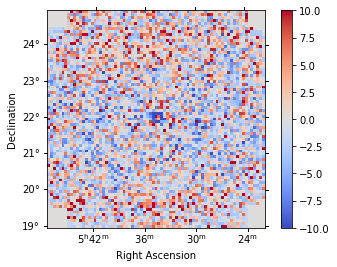

In [7]:
start, end =6,24
cutout = 6 *u.deg
N= 100
smooth = 0.00
geom = dataset.geoms['geom']
result = get_residual2(start, end , dataset ,smooth).cutout(geom.center_skydir, cutout)#.smooth(0.1*u.deg)
vmax =10
result.plot(add_cbar = 1, cmap = 'coolwarm', vmax = vmax, vmin = -vmax);

1000 Poission drawns of the Asimov dataset.

In [8]:
e_start, e_end = dataset.geoms['geom'].axes[0].edges[start],dataset.geoms['geom'].axes[0].edges[end]
observed  = result#.slice_by_idx(dict(energy=slice(start, end)))


res_stat_N = []
datasets_stat = dataset.copy()
datasets_stat.counts =  Map.from_geom(geom = datasets_stat.geoms['geom'])
for n in range(N):
    rng = np.random.RandomState()
    datasets_stat.counts.data = rng.poisson(datasets_stat.npred().data)
    
    result = get_residual2(start, end , datasets_stat ,smooth).cutout(geom.center_skydir,cutout)
    res_stat_N.append(result)#["sqrt_ts"].slice_by_idx(dict(energy=slice(start, end))))

In [9]:
def create_MapDataset(dataset_N):
    mapdatset = MapDataset(models=None, 
                          counts=dataset_N.counts,
                          exposure=dataset_N.exposure,
                          background=None,
                          psf=dataset_N.psf,
                          edisp=dataset_N.edisp,
                          mask_safe=dataset_N.mask_safe,
                          mask_fit=dataset_N.mask_fit,
                          gti=dataset_N.gti,
                          meta_table=dataset_N.meta_table, 
                          name=dataset_N.name)
    
    bkg_model = FoVBackgroundModel(dataset_name=mapdatset.name) 
    models = Models([dataset_N.models[0].copy()])
    print(models)
    mapdatset.models = models
    mapdatset.background = dataset_N.npred_background()
    return mapdatset


DatasetModels

Component 0: SkyModel

  Name                      : main source
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   3.73e-11   +/- 2.2e-13 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    alpha                   :      2.563   +/-    0.01             
    beta                    :      0.085   +/-    0.00             
    lon_0        (frozen)   :     83.631       deg         
    lat_0        (frozen)   :     22.018       deg         
    sigma                   :      0.019   +/-    0.00 deg         
    e            (frozen)   :      0.000                   
    phi          (frozen)   :      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : Y3bqVOQH-bkg
  Datasets names            : ['Y3bqVOQH']
  Spectral model type       : PowerLawN

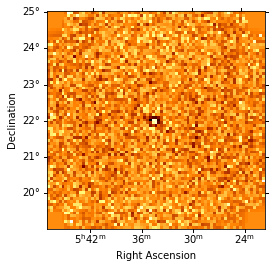

In [10]:
if source == "Crab":
    datasetN_path2 = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/output/'
    datasetN_path2 += '2022-03-22/'
    datasetN_path2 += 'Crab_max_sysamplitude_48.7_downsampling_factor_25_statthreshold1_estart_0.3_eend_120.0/'
        
    path = datasetN_path2
    
    
    
    added = "_008_624"
    path_local_repo = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset'
    path = f'{path_local_repo}/{source}/'
    dataset_N_10 = my_dataset_maps_19.MapDatasetNuisance.read(path+ f'nui_dataset{added}.fits')
    
    with open(path+ f'nui_par{added}.yml', "r") as ymlfile:
        nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
    dataset_N_10.N_parameters = Parameters.from_dict(nui_par )
    with open(path+ f'nui_model{added}.yml', "r") as ymlfile:
        best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
    with open(path+ f'nui_bgmodel{added}.yml', "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset_N_10.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    models = Models.from_dict(best_fit_model )
    models.append(bkg_model)
    dataset_N_10.models =models
    print(dataset_N_10.models)

    emask_map = dataset_N_10.background.geom.energy_mask(
                    energy_min = 0.3*u.TeV,  energy_max =  120*u.TeV)
    dataset_N_10.mask_fit = emask_map
    dataset_N_10.mask_safe = emask_map

    #result_N = get_residual4(start, end , create_MapDataset(dataset_N_10) ,smooth).cutout(geom.center_skydir, cutout)
    result_N = get_residual2(start, end , dataset_N_10 ,smooth).cutout(geom.center_skydir, cutout)
    
    result_N.plot() 

Function used to compute the fourier tranfos of the observed residual and the statistical datasets

In [11]:
half_width_fov = cutout.value /2

def plot_fourier (res_dataset_v0s, stats_res = None, labels_datasets = None):
    #image = mpimg.imread("clouds.png")
    for i,res_dataset_v0 in enumerate(res_dataset_v0s):
        image =res_dataset_v0[0].data
        npix = image.shape[1]
        kfreq = np.fft.fftfreq(npix) * npix
        kfreq2D = np.meshgrid(kfreq, kfreq)
        knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
        knrm = knrm.flatten()
        kbins = np.arange(0.5, npix//2+1, 1.)
        kvals = 0.5 * (kbins[1:] + kbins[:-1])
        print('knrm', len(knrm))
        Abinss = []
        if labels_datasets[i] == 'Standard':
            color = default_colors[1]
        else:
            color = default_colors[1:][i]
        for d in res_dataset_v0:
            image =d.data
            image = np.nan_to_num(image)
            fourier_image = np.fft.fftn(image)
            fourier_amplitudes = np.abs(fourier_image)**2

            fourier_amplitudes = fourier_amplitudes.flatten()
            Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                                 statistic = "mean",
                                                 bins = kbins)
            Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
            plt.loglog(kvals, Abins, '-',#alpha = 0.001963,
                       alpha = 0.02, color = color, label = '')
            Abinss.append(Abins)
        label = ''
        if labels_datasets is not None:
            label += labels_datasets[i]
        plt.errorbar(x = kvals,y =  np.mean(Abinss, axis = 0),
                     yerr = np.std(Abinss,axis = 0), fmt= 'x-', 
                     alpha = 0.9,  label = label ,
                    color = color)
    if stats_res is not None:
        Abinss_stat = []
        for stats_re in stats_res:
            image =stats_re.data
            image = np.nan_to_num(image)

            fourier_image = np.fft.fftn(image)
            fourier_amplitudes = np.abs(fourier_image)**2
            fourier_amplitudes = fourier_amplitudes.flatten()
            Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                                 statistic = "mean",
                                                 bins = kbins)
            Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
            plt.loglog(kvals, Abins, '-',alpha = 5/N, color = 'black', label = '')
            Abinss_stat.append(Abins)
        #plt.loglog(kvals, np.mean(Abinss, axis = 0), 'x-',alpha = 0.9, color = 'black' ,label = 'Stat')
        plt.errorbar(x = kvals,y =  np.mean(Abinss_stat, axis = 0),
                     yerr = np.std(Abinss_stat,axis = 0),
                     fmt = '-',alpha = 0.9, color = 'black' ,label = 'Stat')


    ax = plt.gca() ;    fig = plt.gcf() ;    ax2 = ax.twiny()
    labels = ['1', '2', '5', '10', '20','25']

    def tick_function(X):
        return ["%.2f$^\circ$" % (half_width_fov/x) for x in X]
    ax2.set_xlim(ax.get_xlim())
    new_tick_locations = [1.,2.,5.,10.,20., 25.,]
    ax2.set_xticks(new_tick_locations) ;    ax2.set_xticklabels(tick_function(new_tick_locations))
    yy = ax.get_ylim()
    for i, data in enumerate(new_tick_locations):
        if i >-1:
            ax2.vlines(50/float(labels[::-1][i]), yy[0], yy[1], 
                       color = default_colors[:6][::-1][i],
                      alpha = 0.5)
    ax2.set_xscale('log') ;   ax2.set_xticks(new_tick_locations) ;ax2.set_xticklabels(tick_function(new_tick_locations))
    ax.set_xlabel("$k$") ;    ax2.set_xlabel("Angular Scale") ;    ax2.set_ylabel("Fourier Amplitude")
    ax.set_ylabel("$P(k)$") ;    plt.tight_layout();    plt.grid() ; 
    ax.legend(title= 'Stat+sys', loc = 'lower right')
    #plt.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")
    
    
    ## compute the size of the sys (i.e. look where the observed fourier is not within
    ## the 2simga of the mean
    
    i =0 
    stat_mean, stat_std = np.mean(Abinss_stat, axis = 0), np.std(Abinss_stat, axis = 0)
    observed = np.mean(Abinss, axis = 0)
    while ( ( (stat_mean[i]+ 2*stat_std[i]) < observed[i]) or ((stat_mean[i]- 2*stat_std[i]) > observed[i])):
        #print(((stat_mean[i]- 2*stat_std[i]) > observed[i]))
        i +=1
    size = half_width_fov/(i+1)
    print("Estimated angular size of the Sys:",size , " deg")

    return fig ,  size

In [12]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Resulting plot

knrm 5625
Estimated angular size of the Sys: 0.42857142857142855  deg
saving in angular_size.txt ...


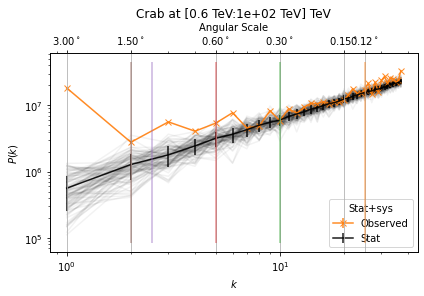

In [13]:
fig, size  = plot_fourier ([[observed]], res_stat_N, labels_datasets=['Observed'])
ax = plt.gca() ;ax.set_title("{} at [{:.1}:{:.1}] TeV".format(source, e_start, e_end));
fig = plt.gcf()
name = f'plots/0_Angular_spectrum'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')

outputpath = f'angular_size.txt'
print(f"saving in {outputpath} ...")
with open(outputpath, 'w') as f:
    f.write(str(size))

Interpretation:
- Diffraction pattern due to the edges visible in both the observed spectrum and stat 
- Deviation up to an angular scale of approx. 0.8 deg
- For this pariticular dataset the bisize of the nuisance parameters is recommendend in the same size. (downsampling : 10)

knrm 5625
knrm 5625
Estimated angular size of the Sys: 1.0  deg


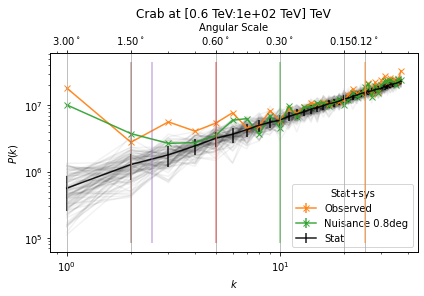

In [14]:
fig  = plot_fourier ([[observed],[result_N]], res_stat_N, labels_datasets=['Observed', "Nuisance 0.8deg"])
ax = plt.gca() ;ax.set_title("{} at [{:.1}:{:.1}] TeV".format(source, e_start, e_end));
fig = plt.gcf()
name = f'plots/0_Angular_spectrum_N'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')


